## 자연어 기반 기후기술분류 AI 경진대회 ☔️❄️☀️☁️
[데이터]

train.csv :		 
train 데이터 
기후기술분류 label 포함
train.shape: (174304, 13)


test.csv : 
test 데이터 
기후기술분류 label 미포함
test.shape: (43576, 12)




sample_submission.csv : 
sample_submission 데이터 
sample_submission.shape: (43576, 2)


labels_mapping.csv : 
label과 기후기술분류체계를 mapping 한 meta data

#### https://dacon.io/competitions/official/235744/overview/description

## 라이브러리 불러오기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import re
import json
import os
import tqdm

from konlpy.tag import Okt

import sklearn
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import log_loss, accuracy_score,f1_score
import tensorflow as tf
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, ModelCheckpoint

## 데이터 보기

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sample_submission=pd.read_csv('sample_submission.csv')
labels_mapping=pd.read_csv('labels_mapping.csv')

In [4]:
train.head(2)

,index,제출년도,사업명,사업_부처명,계속과제여부,내역사업명,과제명,요약문_연구목표,요약문_연구내용,요약문_기대효과,요약문_한글키워드,요약문_영문키워드,label
0,0,2016,농업기초기반연구,농촌진흥청,신규,농산물안전성연구,유전정보를 활용한 새로운 해충 분류군 동정기술 개발,○ 새로운 해충분류군의 동정기술 개발 및 유입확산 추적,(가) 외래 및 돌발해충의 발생조사 및 종 동정\n\n\n ○ 대상해충 : 최...,"○ 새로운 돌발 및 외래해충의 신속, 정확한 동정법 향상\n\n\n○ 돌발 및 외래...","뉴클레오티드 염기서열, 분자마커, 종 동정, 침샘, 전사체","nucleotide sequence, molecular marker, species...",24
1,1,2019,이공학학술연구기반구축(R&D),교육부,신규,지역대학우수과학자지원사업(1년~5년),대장암의 TRAIL 내성 표적 인자 발굴 및 TRAIL 반응 예측 유전자 지도 구축...,최종목표: TRAIL 감수성 표적 유전자를 발굴하고 내성제어 기전을 연구. 발굴된...,1차년도\n1) Microarray를 통한 선천적 TRAIL 내성 표적 후보 유전자...,"1) TRAIL 내성 특이적 표적분자를 발굴하고, 이를 이용한 TRAIL 효과 증진...","대장암,항암제 내성,세포사멸,유전자발굴","TRAIL,Colorectal cancer,TRAIL resistance,Apopt...",0


In [5]:
test.head(2)

,index,제출년도,사업명,사업_부처명,계속과제여부,내역사업명,과제명,요약문_연구목표,요약문_연구내용,요약문_기대효과,요약문_한글키워드,요약문_영문키워드
0,174304,2016,경제협력권산업육성,산업통상자원부,신규,자동차융합부품,R-FSSW 기술 적용 경량 차체 부품 개발 및 품질 평가를 위한 64채널 C-SC...,○ 차체 점용접부의 품질 검사를 위한 64채널 무선 기반 C-Scan 탐촉자 개발\...,○ 1차년도\n\n . 개발 탐촉 시스템의 성능 평가 위한 표준 시편 제작 시...,○ 기술적 파급효과\n\n - 본 연구에서 개발된 R-FSSW 접합 기술은 기존 ...,"마찰교반점용접, 비파괴 검사, 초음파 탐상, 씨 스캔, 용접 품질 평가","Friction Stir Spot Welding, Non-destructive ev..."
1,174305,2018,개인기초연구(과기정통부)(R&D),과학기술정보통신부,계속,신진연구(총연구비5천이상~1.5억이하),다입자계를 묘사하는 편미분방정식에 대한 연구,자연계에는 입자의 개수가 아주 큰 다양한 다입자계가 존재한다. 이런 다입자계의 효...,연구과제1. 무한입자계의 동역학 / 작용소(operator) 방정식에 대한 연구\n...,본 연구는 물리학에서 중요한 대상인 다입자계를 묘사하는 모델방정식의 정당성을 보장하...,"다체계 방정식,동역학의 안정성,양자역학,고전역학,평균장 극한,고전극한,비상대론적 극한","many particle system,stability of dynamics,qua..."


In [6]:
sample_submission.head()

,index,label
0,174304,0
1,174305,0
2,174306,0
3,174307,0
4,174308,0


In [7]:
labels_mapping.head()

,label,소분류
0,0,00. NaN
1,1,01. 원자력 발전
2,2,02. 핵융합 발전
3,3,03. 청정화력발전·효율화
4,4,04. 수력


In [8]:
train.columns

Index(['index', '제출년도', '사업명', '사업_부처명', '계속과제여부', '내역사업명', '과제명', '요약문_연구목표',
       '요약문_연구내용', '요약문_기대효과', '요약문_한글키워드', '요약문_영문키워드', 'label'],
      dtype='object')

In [9]:
test.columns

Index(['index', '제출년도', '사업명', '사업_부처명', '계속과제여부', '내역사업명', '과제명', '요약문_연구목표',
       '요약문_연구내용', '요약문_기대효과', '요약문_한글키워드', '요약문_영문키워드'],
      dtype='object')

In [10]:
print(train.shape)
print(test.shape)
print(sample_submission.shape)
print(labels_mapping.shape)

(174304, 13)
(43576, 12)
(43576, 2)
(46, 2)


In [11]:
train.label.nunique()

46

In [12]:
train.label.value_counts()

0     142571
19      4938
24      3520
23      1840
5       1698
14      1672
18      1550
1       1261
45      1137
36      1060
20      1059
29      1028
31       922
25       810
10       658
27       620
13       575
33       533
34       523
16       506
21       496
28       449
40       441
43       351
8        339
26       316
35       291
2        275
12       268
37       266
38       262
32       260
30       234
39       202
11       200
15       165
17       154
22       148
3        143
7        113
9        106
44        91
6         78
41        67
4         57
42        51
Name: label, dtype: int64

과제명 길이 최댓값: 229
과제명 길이 최솟값: 2
과제명 길이 평균값: 35.84252225995961
과제명 길이 중간값: 34.0


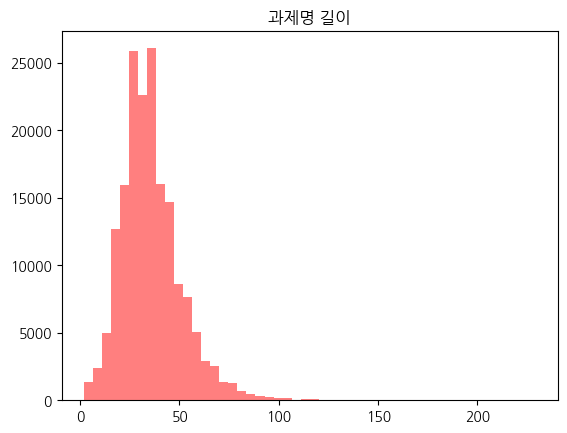

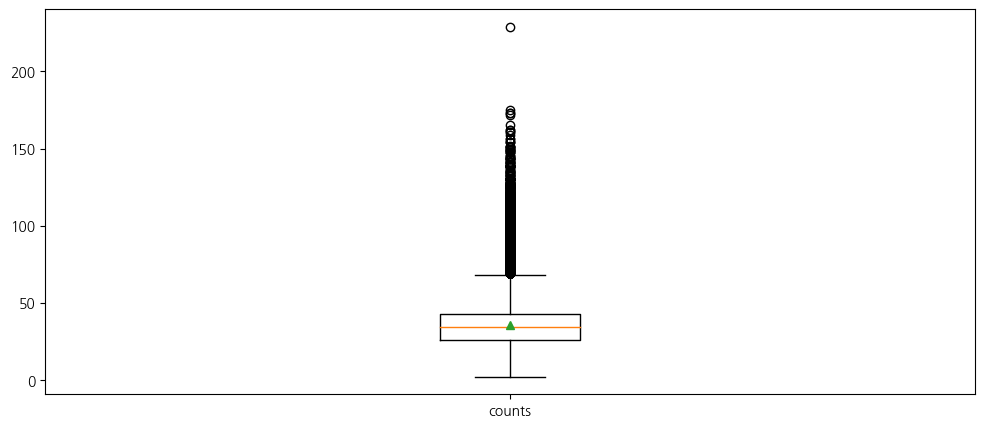

In [13]:
length=train['과제명'].astype(str).apply(len)
plt.hist(length, bins=50, alpha=0.5, color='r', label='word')
plt.title('과제명 길이')
plt.figure(figsize=(12, 5))
plt.boxplot(length, labels=['counts'], showmeans=True)
print('과제명 길이 최댓값: {}'.format(np.max(length)))
print('과제명 길이 최솟값: {}'.format(np.min(length)))
print('과제명 길이 평균값: {}'.format(np.mean(length)))
print('과제명 길이 중간값: {}'.format(np.median(length)))

요약문_연구목표 길이 최댓값: 3951
요약문_연구목표 길이 최솟값: 1
요약문_연구목표 길이 평균값: 318.1008066366807
요약문_연구목표 길이 중간값: 249.0


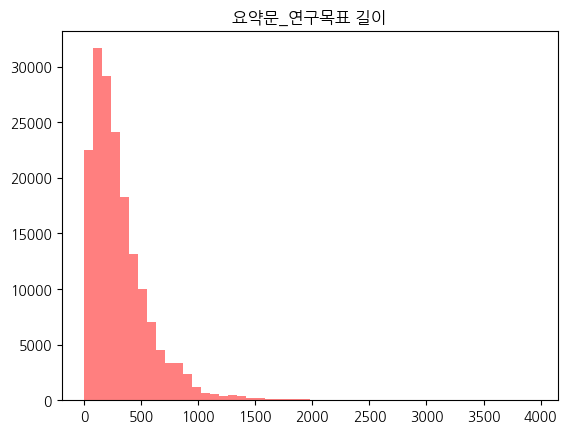

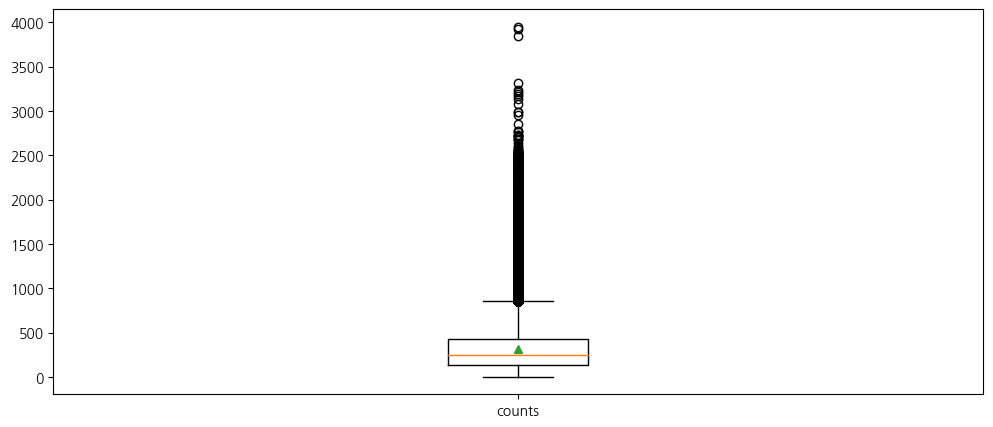

In [14]:
length=train['요약문_연구목표'].astype(str).apply(len)
plt.hist(length, bins=50, alpha=0.5, color='r', label='word')
plt.title('요약문_연구목표 길이')
plt.figure(figsize=(12, 5))
plt.boxplot(length, labels=['counts'], showmeans=True)
print('요약문_연구목표 길이 최댓값: {}'.format(np.max(length)))
print('요약문_연구목표 길이 최솟값: {}'.format(np.min(length)))
print('요약문_연구목표 길이 평균값: {}'.format(np.mean(length)))
print('요약문_연구목표 길이 중간값: {}'.format(np.median(length)))

요약문_연구내용 길이 최댓값: 3999
요약문_연구내용 길이 최솟값: 1
요약문_연구내용 길이 평균값: 699.2930282724435
요약문_연구내용 길이 중간값: 597.0


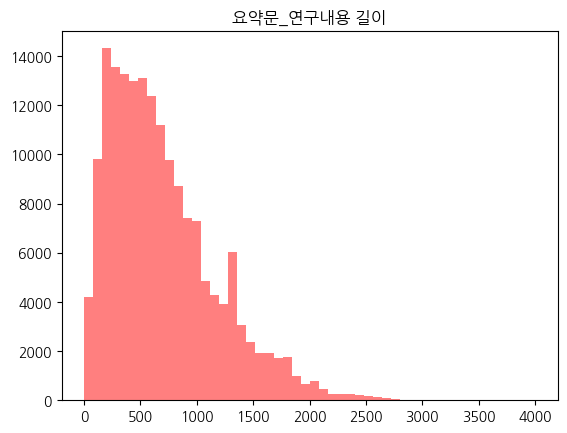

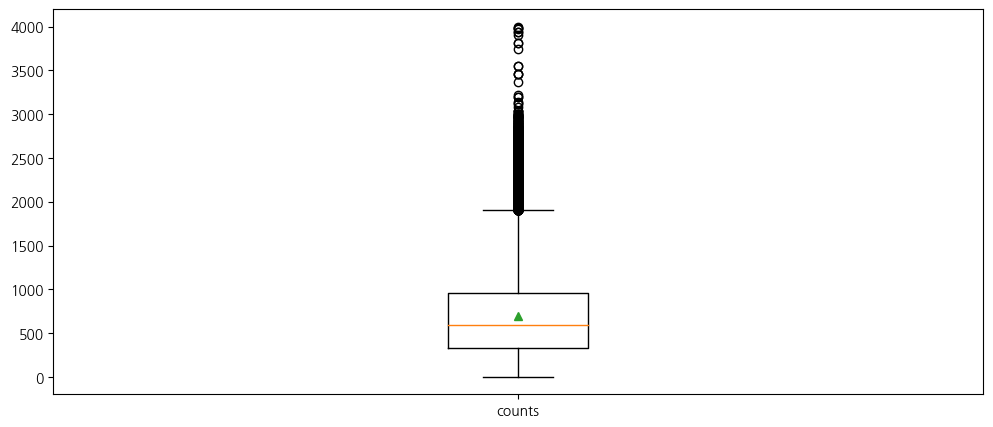

In [15]:
length=train['요약문_연구내용'].astype(str).apply(len)
plt.hist(length, bins=50, alpha=0.5, color='r', label='word')
plt.title('요약문_연구내용 길이')
plt.figure(figsize=(12, 5))
plt.boxplot(length, labels=['counts'], showmeans=True)
print('요약문_연구내용 길이 최댓값: {}'.format(np.max(length)))
print('요약문_연구내용 길이 최솟값: {}'.format(np.min(length)))
print('요약문_연구내용 길이 평균값: {}'.format(np.mean(length)))
print('요약문_연구내용 길이 중간값: {}'.format(np.median(length)))

요약문_기대효과 길이 최댓값: 3649
요약문_기대효과 길이 최솟값: 1
요약문_기대효과 길이 평균값: 400.4864374885258
요약문_기대효과 길이 중간값: 329.0


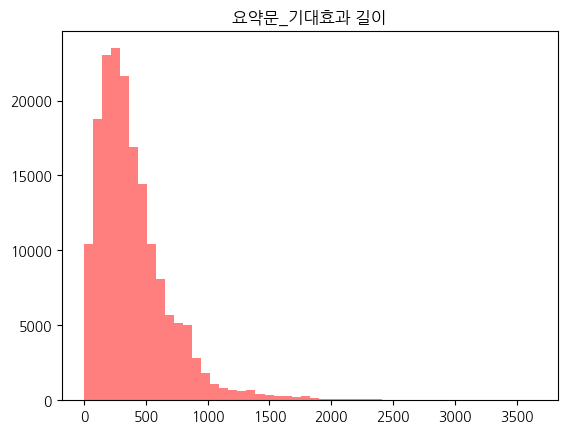

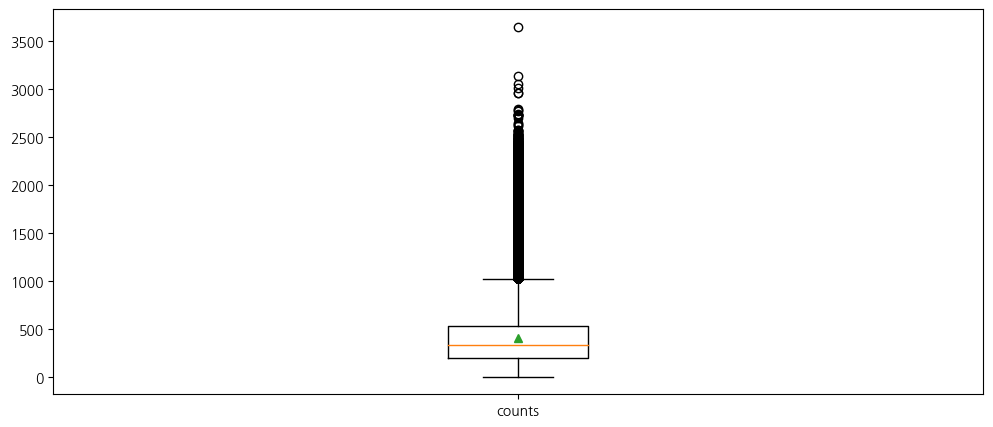

In [16]:
length=train['요약문_기대효과'].astype(str).apply(len)
plt.hist(length, bins=50, alpha=0.5, color='r', label='word')
plt.title('요약문_기대효과 길이')
plt.figure(figsize=(12, 5))
plt.boxplot(length, labels=['counts'], showmeans=True)
print('요약문_기대효과 길이 최댓값: {}'.format(np.max(length)))
print('요약문_기대효과 길이 최솟값: {}'.format(np.min(length)))
print('요약문_기대효과 길이 평균값: {}'.format(np.mean(length)))
print('요약문_기대효과 길이 중간값: {}'.format(np.median(length)))

## 데이터 전처리

In [17]:
train=train[['사업명', '과제명', '요약문_한글키워드', 'label']]
test=test[['사업명', '과제명', '요약문_한글키워드']]

In [19]:
train.head()

,사업명,과제명,요약문_한글키워드,label
0,농업기초기반연구,유전정보를 활용한 새로운 해충 분류군 동정기술 개발,"뉴클레오티드 염기서열, 분자마커, 종 동정, 침샘, 전사체",24
1,이공학학술연구기반구축(R&D),대장암의 TRAIL 내성 표적 인자 발굴 및 TRAIL 반응 예측 유전자 지도 구축...,"대장암,항암제 내성,세포사멸,유전자발굴",0
2,중소기업기술혁신개발,비목질계 셀룰로오스 식물자원을 활용한 기능성 부직포 및 고부가가치 뷰티케어 faci...,"기능성 샐룰로오스 파이버,천연섬유,기능성 부직포,뷰티&amp;케어 제품,미용 솜",0
3,창업성장기술개발(R&D),소화기 암 진단용 분자영상 형광프로브 개발,"분자 진단,형광 조영제,프로브,항체,대장암",0
4,이공학개인기초연구지원,위암환자의 항암제반응예측을 위한 BRCA 발현검사,"BRCA,제자리부합법,조직미세배열,마이크로RNA,위암,항암제반응,젊은 연령/가족성 위암",0


In [20]:
test.head()

,사업명,과제명,요약문_한글키워드
0,경제협력권산업육성,R-FSSW 기술 적용 경량 차체 부품 개발 및 품질 평가를 위한 64채널 C-SC...,"마찰교반점용접, 비파괴 검사, 초음파 탐상, 씨 스캔, 용접 품질 평가"
1,개인기초연구(과기정통부)(R&D),다입자계를 묘사하는 편미분방정식에 대한 연구,"다체계 방정식,동역학의 안정성,양자역학,고전역학,평균장 극한,고전극한,비상대론적 극한"
2,개인기초연구(미래부),저출생체중아 가족을 위한 지역사회중심의 퇴원후 추후관리프로그램 개발,"저출생체중아,추후관리,조기개입,자조모임,가정방문"
3,산학연협력기술개발(R&D),폴리싱용 5축 CNC 정밀 마이크로 시스템 개발,"초정밀가공,폴리싱 가공,마이크로,경면가공,난삭재가공"
4,이공학학술연구기반구축(R&D),다결정재료의 미세조직구조를 고려한 확률론적 응력부식균열 생성예측모델 개발,"결정구조,응력부식균열,확률론적모델"


In [26]:
train['text'] = train['사업명'] + " " + train['과제명'] + " " + train['요약문_한글키워드']
train.head()

,사업명,과제명,요약문_한글키워드,label,text
0,농업기초기반연구,유전정보를 활용한 새로운 해충 분류군 동정기술 개발,"뉴클레오티드 염기서열, 분자마커, 종 동정, 침샘, 전사체",24,농업기초기반연구 유전정보를 활용한 새로운 해충 분류군 동정기술 개발 뉴클레오티드 염...
1,이공학학술연구기반구축(R&D),대장암의 TRAIL 내성 표적 인자 발굴 및 TRAIL 반응 예측 유전자 지도 구축...,"대장암,항암제 내성,세포사멸,유전자발굴",0,이공학학술연구기반구축(R&D) 대장암의 TRAIL 내성 표적 인자 발굴 및 TRAI...
2,중소기업기술혁신개발,비목질계 셀룰로오스 식물자원을 활용한 기능성 부직포 및 고부가가치 뷰티케어 faci...,"기능성 샐룰로오스 파이버,천연섬유,기능성 부직포,뷰티&amp;케어 제품,미용 솜",0,중소기업기술혁신개발 비목질계 셀룰로오스 식물자원을 활용한 기능성 부직포 및 고부가가...
3,창업성장기술개발(R&D),소화기 암 진단용 분자영상 형광프로브 개발,"분자 진단,형광 조영제,프로브,항체,대장암",0,"창업성장기술개발(R&D) 소화기 암 진단용 분자영상 형광프로브 개발 분자 진단,형광..."
4,이공학개인기초연구지원,위암환자의 항암제반응예측을 위한 BRCA 발현검사,"BRCA,제자리부합법,조직미세배열,마이크로RNA,위암,항암제반응,젊은 연령/가족성 위암",0,"이공학개인기초연구지원 위암환자의 항암제반응예측을 위한 BRCA 발현검사 BRCA,제..."


In [27]:
test['text'] = test['사업명'] + " " + test['과제명'] + " " + test['요약문_한글키워드']
test.head()

,사업명,과제명,요약문_한글키워드,text
0,경제협력권산업육성,R-FSSW 기술 적용 경량 차체 부품 개발 및 품질 평가를 위한 64채널 C-SC...,"마찰교반점용접, 비파괴 검사, 초음파 탐상, 씨 스캔, 용접 품질 평가",경제협력권산업육성 R-FSSW 기술 적용 경량 차체 부품 개발 및 품질 평가를 위한...
1,개인기초연구(과기정통부)(R&D),다입자계를 묘사하는 편미분방정식에 대한 연구,"다체계 방정식,동역학의 안정성,양자역학,고전역학,평균장 극한,고전극한,비상대론적 극한",개인기초연구(과기정통부)(R&D) 다입자계를 묘사하는 편미분방정식에 대한 연구 다체...
2,개인기초연구(미래부),저출생체중아 가족을 위한 지역사회중심의 퇴원후 추후관리프로그램 개발,"저출생체중아,추후관리,조기개입,자조모임,가정방문",개인기초연구(미래부) 저출생체중아 가족을 위한 지역사회중심의 퇴원후 추후관리프로그램...
3,산학연협력기술개발(R&D),폴리싱용 5축 CNC 정밀 마이크로 시스템 개발,"초정밀가공,폴리싱 가공,마이크로,경면가공,난삭재가공",산학연협력기술개발(R&D) 폴리싱용 5축 CNC 정밀 마이크로 시스템 개발 초정밀가...
4,이공학학술연구기반구축(R&D),다결정재료의 미세조직구조를 고려한 확률론적 응력부식균열 생성예측모델 개발,"결정구조,응력부식균열,확률론적모델",이공학학술연구기반구축(R&D) 다결정재료의 미세조직구조를 고려한 확률론적 응력부식균...


In [30]:
def preprocessing(text, okt, remove_stopwords=False, stop_words=[]):
    text = re.sub("[^가-힣ㄱ-하-ㅣ ]", "", text)
    word_text = okt.morphs(text, stem=True)
    if remove_stopwords:
        word_review = [token for token in word_text if not token in stop_words]
    return word_review

In [31]:
stop_words=['은','는','이','가', '하','아','것','들','의','있','되','수','보','주','등','한']
okt=Okt()
clean_train_text=[]
clean_test_text=[]

In [32]:
for text in tqdm.tqdm(train['text']):
    try:
        clean_train_text.append(preprocessing(text, okt, remove_stopwords=True, stop_words=stop_words))
    except:
        clean_train_text.append([])

100%|██████████| 174304/174304 [17:30<00:00, 166.00it/s]


In [33]:
for text in tqdm.tqdm(test['text']):
    if type(text) == str:
        clean_test_text.append(preprocessing(text, okt, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_test_text.append([])

100%|██████████| 43576/43576 [04:56<00:00, 147.12it/s]


In [34]:
print(len(clean_train_text))
print(len(clean_test_text))

174304
43576


In [50]:
average = 0
for i in range(0, len(clean_train_text)):
    average = average + len(clean_train_text[i])

average = average/len(clean_train_text)
average

28.902847897925465

In [51]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(clean_train_text)

train_sequences=tokenizer.texts_to_sequences(clean_train_text)
test_sequences=tokenizer.texts_to_sequences(clean_test_text)
word_vocab=tokenizer.word_index

train_inputs=pad_sequences(train_sequences, maxlen=40, padding='post')
test_inputs=pad_sequences(test_sequences, maxlen=40, padding='post')

In [52]:
print(train_inputs.shape)
print(test_inputs.shape)

(174304, 40)
(43576, 40)


In [53]:
labels=np.array(train['label'])
len(set(labels))

46

In [54]:
DATA_IN_PATH='./data/'
TRAIN_INPUT_DATA = 'train_input.npy'
TEST_INPUT_DATA = 'test_input.npy'

import os
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)
    
np.save(open(DATA_IN_PATH+TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH+TEST_INPUT_DATA, 'wb'), test_inputs)

data_configs={}
data_configs['vocab']=word_vocab
data_configs['vocab_size'] = len(word_vocab)+1
json.dump(data_configs, open(DATA_IN_PATH+'data_configs.json', 'w'), ensure_ascii=False)

## 모델링 및 학습

In [65]:
vocab_size =data_configs['vocab_size']
embedding_dim = 32
max_length = 40
oov_tok = "<OOV>"

In [68]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(46, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 40, 32)            1306400   
                                                                 
 global_average_pooling1d_6   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               4224      
                                                                 
 dense_7 (Dense)             (None, 46)                5934      
                                                                 
Total params: 1,316,558
Trainable params: 1,316,558
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [70]:
num_epochs = 100
history = model.fit(train_inputs, labels, 
                    epochs=num_epochs, callbacks=[early_stop],
                    validation_split=0.2)

Epoch 1/100
   1/4358 [..............................] - ETA: 28:06 - loss: 3.8328 - accuracy: 0.0000e+00

2022-12-19 01:39:20.850715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4358/4358 [==============================] - ETA: 0s - loss: 0.7462 - accuracy: 0.8393

2022-12-19 01:40:06.638080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4358/4358 [==============================] - 50s 11ms/step - loss: 0.7462 - accuracy: 0.8393 - val_loss: 0.5383 - val_accuracy: 0.8605
Epoch 2/100
4358/4358 [==============================] - 49s 11ms/step - loss: 0.4187 - accuracy: 0.8842 - val_loss: 0.4278 - val_accuracy: 0.8821
Epoch 3/100
4358/4358 [==============================] - 52s 12ms/step - loss: 0.3060 - accuracy: 0.9092 - val_loss: 0.3826 - val_accuracy: 0.8933
Epoch 4/100
4358/4358 [==============================] - 50s 11ms/step - loss: 0.2430 - accuracy: 0.9261 - val_loss: 0.3640 - val_accuracy: 0.8998
Epoch 5/100
4358/4358 [==============================] - 51s 12ms/step - loss: 0.2010 - accuracy: 0.9382 - val_loss: 0.3646 - val_accuracy: 0.9044
Epoch 6/100
4358/4358 [==============================] - 52s 12ms/step - loss: 0.1697 - accuracy: 0.9467 - val_loss: 0.3781 - val_accuracy: 0.9072
Epoch 7/100
4358/4358 [==============================] - 50s 12ms/step - loss: 0.1462 - accuracy: 0.9536 - val_loss: 0.3959 - val_

In [71]:
df_hist = pd.DataFrame(history.history)
df_hist

,loss,accuracy,val_loss,val_accuracy
0,0.746151,0.839275,0.538253,0.860532
1,0.418728,0.884239,0.427800,0.882103
2,0.306030,0.909225,0.382609,0.893262
3,0.243046,0.926135,0.363965,0.899773
4,0.201002,0.938161,0.364555,0.904449
5,0.169732,0.946688,0.378113,0.907174
6,0.146208,0.953644,0.395911,0.909067
7,0.126775,0.959654,0.404095,0.906945
8,0.111351,0.964466,0.420978,0.910358


<AxesSubplot:>

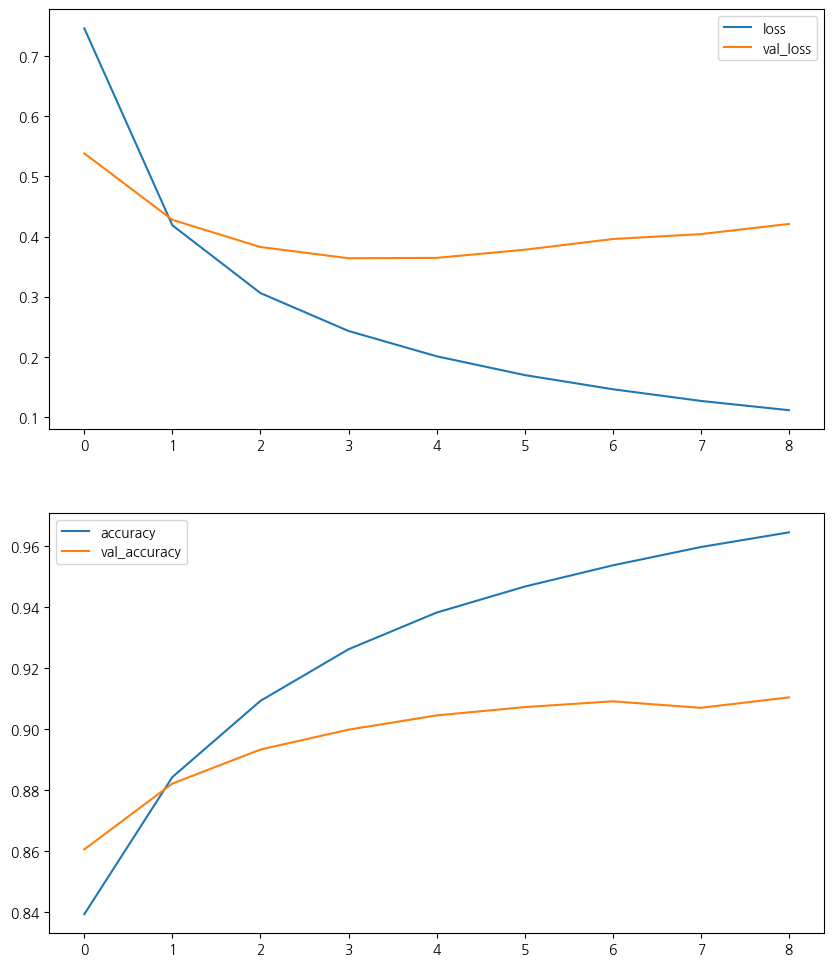

In [72]:
figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,12))
df_hist[['loss', 'val_loss']].plot(ax=axes[0])
df_hist[['accuracy','val_accuracy']].plot(ax=axes[1])

## 예측 및 제출

In [73]:
pred=model.predict(test_inputs)
pred=tf.argmax(pred, axis=1)

  23/1362 [..............................] - ETA: 6s

2022-12-19 01:52:58.778407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1362/1362 [==============================] - 3s 2ms/step


In [74]:
sample_submission['label']=pred

In [75]:
sample_submission

,index,label
0,174304,0
1,174305,0
2,174306,0
3,174307,0
4,174308,0
...,...,...
43571,217875,0
43572,217876,0
43573,217877,2
43574,217878,0


In [76]:
sample_submission.to_csv('baseline.csv', index=False)